In [2]:
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import os
import numpy as np
import torch.nn as nn
import pandas as pd
import librosa
import librosa.display
from torch.utils.data import sampler
import torch.optim as optim
import json
import cv2
import matplotlib.pyplot as plt

print(torch.__version__)
print(torchaudio.__version__)

1.11.0
0.11.0


In [3]:
class DAPSDatasetHelper():
    #initialization 
    def __init__(self):
        self.sample_rate=8000
        self.dir= "./daps_dict_unet2.json"
        openfile=open(self.dir, "r")
        self.dataset_dict= json.load(openfile)
        indx=2
        self.keys={}
        for key  in self.dataset_dict.keys():
            if(key=="produced"):
                self.keys[1]=key
            else:
                self.keys[indx]=key
                indx+=1

        self.num_files_per_category=len(self.dataset_dict["produced"].keys())

    #get the indexed file and sample rate
    def get_indxd_file(self,indx,isLabel=False):
        if(isLabel):
            category=self.keys[1]
        else:
            #category=self.keys[np.random.randint(2,len(self.keys))]
            #consider one category for now
            category=self.keys[3]
        data=cv2.imread(self.dataset_dict[category][str(indx)],0)
        data= cv2.normalize(data, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        Id= self.dataset_dict[category][str(indx)].split("/")[-1].split('.')[0]
        return (data,Id)

In [4]:
class DAPS(Dataset):
    def __init__(self):
        #super().__init__(self)
        self.daps= DAPSDatasetHelper()

    def __getitem__(self, index):
        data,id=self.daps.get_indxd_file(index)
        label,id=self.daps.get_indxd_file(index,True)
        return (data,label)

    def __len__(self):
        return (len(self.daps.keys)-1)*self.daps.num_files_per_category

In [5]:
dtype = torch.float32 # we will be using float throughout this tutorial
USE_GPU = True
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

cuda


In [6]:
def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

In [79]:
NUM_TRAIN=8000
NUM_VAL=1000
NUM_TEST=1000
print_every = 100
dataset_train = DAPS()
batch_size=8
loader_train = DataLoader(dataset_train, batch_size=batch_size, num_workers=0,
                          sampler=sampler.SequentialSampler(range(NUM_TRAIN)))
loader_val= DataLoader(dataset_train, batch_size=batch_size, num_workers=0,
                          sampler=sampler.SequentialSampler(range(NUM_TRAIN,NUM_VAL+NUM_TRAIN)))
loader_test = DataLoader(dataset_train, batch_size=batch_size, num_workers=0,
                          sampler=sampler.SequentialSampler(range(NUM_VAL+NUM_TRAIN, NUM_VAL+NUM_TRAIN+NUM_TEST)))

helper= DAPSDatasetHelper()


In [80]:
print(dataset_train.daps.keys)

{2: 'iphone_bedroom1', 3: 'iphone_balcony1', 4: 'ipad_confroom1', 5: 'clean', 6: 'iphone_livingroom1', 7: 'ipad_confroom2', 8: 'ipad_livingroom1', 9: 'cleanraw', 1: 'produced', 10: 'ipadflat_office1', 11: 'ipadflat_confroom1', 12: 'ipad_office1', 13: 'ipad_balcony1', 14: 'ipad_bedroom1', 15: 'sample', 16: 'ipad_office2'}


In [81]:
class block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                kernel_size=(3,3),stride=1,padding=1)
        #self.bnorm1=nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=(3,3),stride=1,padding=1)
        #self.bnorm2=nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        return x


class encoder(nn.Module):
    def __init__(self, c_list):
        super().__init__()
        self.pool = nn.MaxPool2d(kernel_size=(2,1),stride=(2,1))
        self.blocks = nn.ModuleList([block(c_list[i], c_list[i+1]) for i in range(len(c_list)-1)])

    def forward(self, x):
        filters = []
        for block in self.blocks:
            x = block(x)
            #print("conv output",x.shape)
            filters.append(x)
            x = self.pool(x)
            #print("pool output",x.shape)
        return filters


class decoder(nn.Module):
    def __init__(self, c_list):
        super().__init__()
        self.up_cov = nn.ModuleList([nn.ConvTranspose2d(c_list[i], c_list[i+1], kernel_size=(2,1), stride=(2,1))
                                                                    for i in range(len(c_list)-1)])
        self.conv_blocks = nn.ModuleList([block(c_list[i], c_list[i+1]) for i in range(len(c_list)-1)])
        

    def forward(self, x, features):    
        for i in range(len(self.conv_blocks)):
            x = self.up_cov[i](x)
           # print("up conv output",features[i].shape, x.shape)
            x = torch.cat([x, features[i]], dim=1)
            x = self.conv_blocks[i](x)
            #print("concat output",x.shape)
        return x

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        c_list=[1, 16, 32, 64, 128]
        self.enc_blocks = encoder(c_list)
        self.dec_blocks = decoder(c_list[::-1][:-1])
        self.last_layer = nn.Conv2d(c_list[1], 1, kernel_size=1,stride=1,padding=0)

    def forward(self, x):
        filters = self.enc_blocks(x)
        x = self.dec_blocks(filters[-1], filters[::-1][1:])
        return self.last_layer(x)

In [74]:
#SNR loss where yhat is average power spectrum of de-nonlinearised/denoised signal/ clean signal power 
def Loss_SNR(yhat,y):
    yhat=yhat.cpu().detach().numpy()
    y=y.cpu().detach().numpy()
    loss= np.mean(10*np.log(np.abs(yhat-y)/y))
    loss=torch.from_numpy(loss)
    loss=loss.to(device=device,dtype=dtype)
    return loss

#SNR loss where yhat is average power spectrum of de-nonlinearised/denoised signal/ clean signal power 
def Loss_MSE(yhat,y,lossfn):
    loss=lossfn(yhat,y)
    return loss


In [75]:
def check_accuracy(loader, model,lossfn):
    print('Checking accuracy on validation set')
    model.eval()  # set model to evaluation mode
    mse=0
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=dtype)
            x=x.unsqueeze(1)
            y=y.unsqueeze(1) 
            yhat = model(x)
            mse+= lossfn(y,yhat)
        mse = mse / len(loader)
        print("Validation loss is", mse.cpu().numpy())
        return  mse.cpu().numpy()

In [89]:
print_every=1
def train_model(model, optimizer, scheduler ,epochs=1):
    """
    Train a model on DAPS.
    
    Inputs:
    - model_fn: A Python function that performs the forward pass of the model.
      It should have the signature scores = model_fn(x, params) where x is a
      PyTorch Tensor of image data, params is a list of PyTorch Tensors giving
      model weights, and scores is a PyTorch Tensor of shape (N, C) giving
      scores for the elements in x.
    - params: List of PyTorch Tensors giving weights for the model
    - learning_rate: Python scalar giving the learning rate to use for SGD
    
    Returns: val loss and train loss
    """
    val_loss=[]
    train_loss=[]
    lossfn=nn.SmoothL1Loss()
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        running_loss = 0
        for t, (x, y) in enumerate(loader_train):
            
            #print(y.shape)          
            #iterate over each stft frame 
            x=x.to(device=device, dtype=dtype)
            y=y.to(device=device, dtype=dtype)

            x=x.unsqueeze(1)
            y=y.unsqueeze(1) 

            # Forward pass: compute scores and loss
            yhat = model(x)
            
            loss = Loss_MSE(yhat, y, lossfn)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()
            # Update parameters. We don't want to backpropagate through the
            running_loss += loss.item()
            

        if t % print_every == 0:
            print('Epoch %d, Iteration %d, loss = %.4f' % (e, t, (running_loss/len(loader_train))))
            train_loss.append(running_loss/len(loader_train))
            #check_accuracy_part2(loader_val, model_fn, params)
            
        vloss=check_accuracy(loader_val,model,lossfn)
        val_loss.append(vloss)
        scheduler.step(loss)
    return (train_loss,val_loss)

In [90]:
learning_rate = 1e-4

model = UNet()
# you can use Nesterov momentum in optim.SGD
#optimizer = optim.SGD(model.parameters(), lr=learning_rate,
#                     momentum=0.9, nesterov=True)
# you can use Nesterov momentum in optim.SGD
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

In [91]:
(train_loss,val_loss)=train_model(model, optimizer, scheduler,50)


Epoch 0, Iteration 999, loss = 0.0228
Checking accuracy on validation set
Validation loss is 0.021837903
Epoch 1, Iteration 999, loss = 0.0208
Checking accuracy on validation set
Validation loss is 0.019664481
Epoch 2, Iteration 999, loss = 0.0195
Checking accuracy on validation set
Validation loss is 0.018627783
Epoch 3, Iteration 999, loss = 0.0189
Checking accuracy on validation set
Validation loss is 0.017875586
Epoch 4, Iteration 999, loss = 0.0185
Checking accuracy on validation set
Validation loss is 0.017454172
Epoch 5, Iteration 999, loss = 0.0182
Checking accuracy on validation set
Validation loss is 0.017233498
Epoch 6, Iteration 999, loss = 0.0179
Checking accuracy on validation set
Validation loss is 0.017204857
Epoch 7, Iteration 999, loss = 0.0177
Checking accuracy on validation set
Validation loss is 0.017156957
Epoch 8, Iteration 999, loss = 0.0176
Checking accuracy on validation set
Validation loss is 0.017144222
Epoch 9, Iteration 999, loss = 0.0175
Checking accuracy

In [93]:
model_path= "./misc/model.pth"
torch.save(model.state_dict(),model_path)
model=UNet()
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [96]:
dataset=DAPSDatasetHelper()
test_index=9030
img_test,_= dataset.get_indxd_file(test_index)
img_label,_= dataset.get_indxd_file(test_index,True)
img = torch.tensor(img_test)
img=img.unsqueeze(0)
img=img.unsqueeze(0)
img=img.to(dtype=torch.float32)
model.eval()
with torch.no_grad():
    out=model(img)
out=out.squeeze(0)
out=out.squeeze(0)

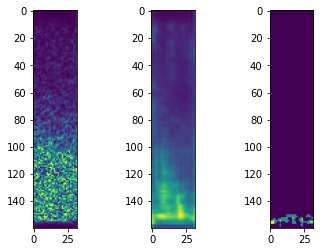

In [97]:
plt.figure()
plt.subplot(1,3,1)
plt.imshow(img_test)
plt.subplot(1,3,2)
plt.imshow(out.cpu().numpy())
plt.subplot(1,3,3)
plt.imshow(img_label)

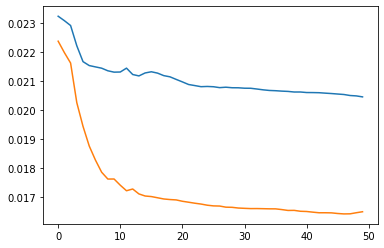

In [88]:
plt.plot(train_loss)
plt.plot(val_loss)

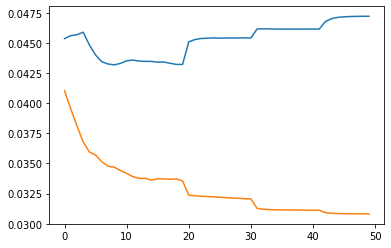

In [ ]:
plt.plot(train_loss)
plt.plot(val_loss)

In [ ]:
class AdaptiveFilters():
    def __init__(self,mu,taps):
        self.e=0
        self.w=np.zeros((taps,1))
        self.xd=np.zeros((taps,1))
        self.mu=mu
        self.N=taps

class LMS(AdaptiveFilters):
    #initialize
    def __init__(self,mu,taps):
        super().__init__(mu,taps)

    #updates the filter sample by sample and updates weights sample by sample
    def run(self,x,d):
        N=self.N
        #udpate delay line 
        self.xd[0]=x
        y = np.dot(self.w.T,self.xd)
        
        e = d - y
        
        Fw=self.mu*np.multiply(self.xd,e)
        
        Fw=Fw.reshape(Fw.shape[0],-1)
        
        self.w = self.w + Fw
    
        y = np.dot(self.w.T,self.xd)
        #shift delay line
        self.xd[1:N-1]=self.xd[0:N-2]
        self.e=e

        return (y,e,w)


class NLMS(AdaptiveFilters):
    #initialize
    def __init__(self,mu,taps):
        super().__init__(mu,taps)

    #updates the filter sample by sample and updates weights sample by sample
    def run(self,x,d):
        N=self.N
        #udpate delay line 
        self.xd[0]=x
        #compute filter output
        y = np.dot(self.w.T,self.xd)
        #compute input energy
        pw=np.linalg.norm(self.xd)
        #calculate error
        e = d - y
        #normalize by input energy
        e= e/(pw+0.0000001)
        #compute gradients
        Fw=self.mu*np.multiply(self.xd,e)
        
        Fw=Fw.reshape(Fw.shape[0],-1)
        #weight update
        self.w = self.w + Fw
    
        #filtered output post update
        y = np.dot(self.w.T,self.xd)
        #shift delay line
        self.xd[1:]=self.xd[:-1]
        self.e=e

        #return current output sample, current error sample and current weights
        return (y,e,self.w)


In [ ]:
desired,sr= librosa.load('../dataset/AEC-Challenge/datasets/synthetic/nearend_mic_signal/nearend_mic_fileid_0.wav')
input,sr=librosa.load('../dataset/AEC-Challenge/datasets/synthetic/farend_speech/farend_speech_fileid_0.wav')
echo,sr=librosa.load('../dataset/AEC-Challenge/datasets/synthetic/echo_signal/echo_fileid_0.wav')
near_end,sr= librosa.load('../dataset/AEC-Challenge/datasets/synthetic/nearend_speech/nearend_speech_fileid_0.wav')

In [ ]:
#test wrapper for NLMS filter on aec data for single talk case
taps=1024
block_size=80
frame_length=318
lmscls= NLMS(0.1,taps)
w=np.zeros((taps,1))
#pad the desired signal to account for initial delay
d=np.reshape(desired,(desired.shape[0],-1))
x=np.reshape(input,(input.shape[0],-1))
if(not np.mod(len(x),block_size)==0):
     x=np.concatenate((np.zeros((np.mod(len(x),block_size),1)),x),axis=0)
if(not np.mod(len(d),block_size)==0):
     d=np.concatenate((np.zeros((np.mod(len(d),block_size),1)),d),axis=0)
y=np.zeros_like(x)
e=np.zeros_like(x)
ref=np.concatenate((np.zeros((frame_length-block_size,1)),d),axis=0)
fft_d=np.zeros((frame_length,1))
print(x.len)
for i in range(0,len(x),block_size):
     #udpate delay line
    print(i)
    fft_d[frame_length-block_size:,:]=x[i:i+block_size]
    for j in range(0,block_size):
         (y[i+j],e[i+j],w)=lmscls.run(fft_d[j],ref[i+j])

    fft_d[:frame_length-block_size]=fft_d[block_size:]

0
80
160
240
320
400
480
560
640
720
800
880
960
1040
1120
1200
1280
1360
1440
1520
1600
1680
1760
1840
1920
2000
2080
2160
2240
2320
2400
2480
2560
2640
2720
2800
2880
2960
3040
3120
3200
3280
3360
3440
3520
3600
3680
3760
3840
3920
4000
4080
4160
4240
4320
4400
4480
4560
4640
4720
4800
4880
4960
5040
5120
5200
5280
5360
5440
5520
5600
5680
5760
5840
5920
6000
6080
6160
6240
6320
6400
6480
6560
6640
6720
6800
6880
6960
7040
7120
7200
7280
7360
7440
7520
7600
7680
7760
7840
7920
8000
8080
8160
8240
8320
8400
8480
8560
8640
8720
8800
8880
8960
9040
9120
9200
9280
9360
9440
9520
9600
9680
9760
9840
9920
10000
10080
10160
10240
10320
10400
10480
10560
10640
10720
10800
10880
10960
11040
11120
11200
11280
11360
11440
11520
11600
11680
11760
11840
11920
12000
12080
12160
12240
12320
12400
12480
12560
12640
12720
12800
12880
12960
13040
13120
13200
13280
13360
13440
13520
13600
13680
13760
13840
13920
14000
14080
14160
14240
14320
14400
14480
14560
14640
14720
14800
14880
14960
15040
15120
1

ValueError: could not broadcast input array from shape (38,1) into shape (80,1)

Text(0.5, 1.0, 'far end reference(input signal)')

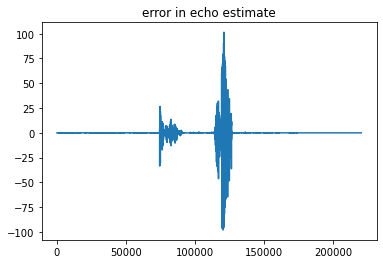

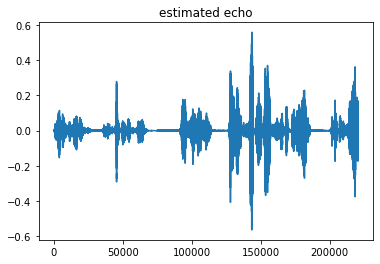

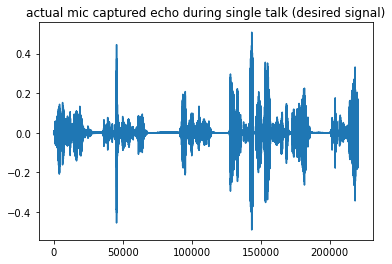

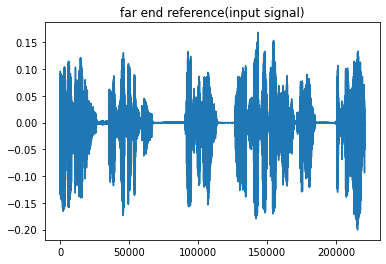

In [ ]:
plt.figure()
plt.plot(e)
plt.title("error in echo estimate")
plt.figure()
plt.plot(y)
plt.title("estimated echo")
plt.figure()
plt.plot(echo)
plt.title("actual mic captured echo during single talk (desired signal)")
plt.figure()
plt.plot(x)
plt.title("far end reference(input signal)")

In [ ]:
torch.cuda.get_device_properties(0)

_CudaDeviceProperties(name='GeForce RTX 2080 Ti', major=7, minor=5, total_memory=11016MB, multi_processor_count=68)